In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations
from dataclasses import dataclass
import numpy as np

In [7]:
#Config

seed = 42
#set_config(transform_output = "pandas")
sns.set_style("darkgrid")


# Load Data

In [8]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

# Calculating Bivariate Stats

In [9]:
@dataclass
class StatMeta:
    columns: list
    missing: float
    dtype: str
    unique_vals: int

def bivariate_stats(df: pd.DataFrame, target: str, round_to: int = 3):
    """
    Generate bivariate statistics between each feature and a target column in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target (str): Target column name.
        round_to (int): Decimal precision for rounded values.

    Returns:
        pd.DataFrame: Summary of statistics between each feature and the target.
    """
    columns = ['missing', 'type', 'unique_values', 'skew',
               'pearson_pvalue', 'r', 'y = mx + b', 'spearman', 'spearman_pvalue', 
               'kendalltau', 'kendalltau_pvalue', 
               'chi2', 'chi2_pvalue', 
               'ttest', 'ttest_pvalue', 
               'F', 'F_pvalue']
    output_df = pd.DataFrame(columns=columns)

    for feature in df:
        if feature == target:
            continue

        df_temp = df[[feature, target]].dropna()
        missing = round((len(df) - len(df_temp)) / len(df) * 100, round_to)
        dtype = df_temp[feature].dtype
        unique_vals = df_temp[feature].nunique()
        meta = StatMeta(columns, missing, dtype, unique_vals)

        if len(df_temp) < 2:
            output_df.loc[feature] = result_row(meta)
            continue
        
        # no variance = no stats
        if unique_vals == 1:
            output_df.loc[feature] = result_row(meta)
            continue

        if pd.api.types.is_numeric_dtype(df_temp[feature]) and pd.api.types.is_numeric_dtype(df_temp[target]):
            output_df.loc[feature] = handle_numeric_numeric(df_temp, feature, target, round_to, meta)
        elif not pd.api.types.is_numeric_dtype(df_temp[feature]) and not pd.api.types.is_numeric_dtype(df_temp[target]):
            output_df.loc[feature] = handle_categorical_categorical(df_temp, feature, target, round_to, meta)
        elif pd.api.types.is_numeric_dtype(df_temp[feature]) and df_temp[target].nunique() == 2:
            output_df.loc[feature] = handle_ttest(df_temp, feature, target, round_to, meta)
        elif pd.api.types.is_numeric_dtype(df_temp[target]) and df_temp[feature].nunique() == 2:
            output_df.loc[feature] = handle_ttest(df_temp, target, feature, round_to, meta, flip=True)
        elif is_invalid_categorical(df_temp, feature, target):
            output_df.loc[feature] = result_row(meta)
        elif pd.api.types.is_numeric_dtype(df_temp[feature]):
            output_df.loc[feature] = handle_anova(df_temp, feature, target, round_to, meta)
        else:
            output_df.loc[feature] = handle_anova(df_temp, target, feature, round_to, meta)

    return output_df

def result_row(meta: StatMeta, **kwargs):
    """
    Build a result row for the output DataFrame with provided statistics.

    Parameters:
        columns (list): All column headers for the output.
        missing (float): Percentage of missing data.
        dtype: Data type of the feature.
        unique_vals (int): Number of unique values.
        **kwargs: Additional statistic key-value pairs.

    Returns:
        dict: Row formatted with all required keys.
    """
    row = {col: '-' for col in meta.columns}
    row.update({
        'missing': f'{meta.missing}%',
        'type': meta.dtype,
        'unique values': meta.unique_vals
    })
    row.update(kwargs)
    return row

def handle_numeric_numeric(df_temp, feature, target, round_to, meta: StatMeta):
    """
    Compute correlations and regression line for numeric-numeric feature-target pairs.
    """
    linreg = stats.linregress(df_temp[feature], df_temp[target])
    spearman = stats.spearmanr(df_temp[feature], df_temp[target])
    kendall = stats.kendalltau(df_temp[feature], df_temp[target])
    return result_row(
        meta,
        skew=round(df_temp[feature].skew(), round_to),
        pearson_pvalue=round(linreg.pvalue, round_to),
        r=round(linreg.rvalue, round_to),
        **{"y = mx + b": (
            f"y = {round(linreg.slope, round_to)}x + {round(linreg.intercept, round_to)}")},
        spearman=round(spearman.statistic, round_to),
        spearman_pvalue=round(spearman.pvalue, round_to),
        kendalltau=round(kendall.statistic, round_to),
        kendalltau_pvalue=round(kendall.pvalue, round_to)
    )

def handle_categorical_categorical(df_temp, feature, target, round_to, meta: StatMeta):
    """
    Compute Chi-squared test for categorical-categorical feature-target pairs.
    """
    chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df_temp[feature], df_temp[target]))
    return result_row(meta, chi2_pvalue=round(p, round_to), chi2=round(chi2, round_to))

def handle_ttest(df_temp, numeric_col, cat_col, round_to, meta: StatMeta, flip=False):
    """
    Compute T-test for numeric-categorical feature-target pairs (binary categorical only).

    Parameters:
        flip (bool): Whether the roles of numeric and categorical columns are swapped.
    """
    unique = df_temp[cat_col].unique()
    group1 = df_temp[df_temp[cat_col] == unique[0]][numeric_col]
    group2 = df_temp[df_temp[cat_col] == unique[1]][numeric_col]
    tstat, p = stats.ttest_ind(group1, group2)
    skew = round(df_temp[numeric_col].skew(), round_to) if not flip else '-'
    return result_row(meta, ttest_pvalue=round(p, round_to), ttest=round(tstat, round_to), skew=skew)

def handle_anova(df_temp, numeric_col, cat_col, round_to, meta: StatMeta):
    """
    Compute ANOVA for numeric-categorical pairs with more than two groups.
    """
    groups = [
        df_temp[df_temp[cat_col] == cat][numeric_col]
        for cat in df_temp[cat_col].unique()
    ]
    # Keep only groups with at least 2 samples
    valid_groups = [g for g in groups if len(g) >= 2]

    # check the number of valid groups
    if len(valid_groups) < 2:
        return result_row(meta)
    
    #if number of valid groups is 2, perform t-test
    if len(valid_groups) == 2:
        tstat, p = stats.ttest_ind(valid_groups[0], valid_groups[1])
        return result_row(
            meta,
            F_pvalue=round(p, round_to),
            ttest=round(tstat, round_to),
            skew=round(df_temp[numeric_col].skew(), round_to),
        )
    
    try:
        # Perform ANOVA
        f, p = stats.f_oneway(*groups)
        return result_row(
            meta,
            F_pvalue=round(p, round_to),
            F=round(f, round_to),
            skew=round(df_temp[numeric_col].skew(), round_to),
        )
    except ValueError as ve:

        # Handle specific ValueError exception
        print(f"ValueError: {ve}")  # Optional logging
        return result_row(meta)
    except TypeError as te:
        # Handle specific TypeError exception
        print(f"TypeError: {te}")  # Optional logging
        return result_row(meta)


def is_invalid_categorical(df_temp, feature, target):
    """
    Check whether both feature and target are non-numeric with all unique values.
    """
    return (not pd.api.types.is_numeric_dtype(df_temp[feature]) and df_temp[feature].nunique() == len(df_temp)) or \
           (not pd.api.types.is_numeric_dtype(df_temp[target]) and df_temp[target].nunique() == len(df_temp))


## Example

In [10]:
insurance_bivariate_stats = bivariate_stats(df = insurance,
                                            target = 'charges')

insurance_bivariate_stats.head()


,missing,type,unique_values,skew,pearson_pvalue,r,y = mx + b,spearman,spearman_pvalue,kendalltau,kendalltau_pvalue,chi2,chi2_pvalue,ttest,ttest_pvalue,F,F_pvalue
age,0.0%,int64,-,0.056,0.0,0.299,y = 257.723x + 3165.885,0.534,0.0,0.475,0.0,-,-,-,-,-,-
sex,0.0%,object,-,-,-,-,-,-,-,-,-,-,-,-2.098,0.036,-,-
bmi,0.0%,float64,-,0.284,0.0,0.198,y = 393.873x + 1192.937,0.119,0.0,0.083,0.0,-,-,-,-,-,-
children,0.0%,int64,-,0.938,0.013,0.068,y = 683.089x + 12522.496,0.133,0.0,0.103,0.0,-,-,-,-,-,-
smoker,0.0%,object,-,-,-,-,-,-,-,-,-,-,-,46.665,0.0,-,-


# Plots

## Regression plot

In [21]:
def compute_regression_statistics(df: pd.DataFrame, column_1: str, column_2: str, round_to: int = 3) -> dict:
    """
    Compute regression and correlation statistics between two numeric columns.

    Returns:
        dict: Dictionary containing regression slope, intercept, p-values, correlations, and skewness.
    """
    result_lin_regression = stats.linregress(df[column_1], df[column_2])
    res_spearman = stats.spearmanr(df[column_1], df[column_2])
    res_kendall = stats.kendalltau(df[column_1], df[column_2])

    return {
        'slope': round(result_lin_regression.slope, round_to),
        'intercept': round(result_lin_regression.intercept, round_to),
        'pearson_r': round(result_lin_regression.rvalue, round_to),
        'pearson_p': round(result_lin_regression.pvalue, round_to),
        'spearman': round(res_spearman.statistic, round_to),
        'spearman_p': round(res_spearman.pvalue, round_to),
        'kendall': round(res_kendall.statistic, round_to),
        'kendall_p': round(res_kendall.pvalue, round_to),
        'skew_1': round(df[column_1].skew(), round_to),
        'skew_2': round(df[column_2].skew(), round_to),
    }


def generate_regression_plot(df: pd.DataFrame, column_1: str, column_2: str, round_to: int = 3):
    """
    Generate a linear regression plot between two numeric columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input data.
        column_1 (str): Column name for the X-axis.
        column_2 (str): Column name for the Y-axis.
        round_to (int): Decimal precision for statistical results.

    Returns:
        None
    """
    df = df[[column_1, column_2]].dropna()

    if not (pd.api.types.is_numeric_dtype(df[column_1]) and pd.api.types.is_numeric_dtype(df[column_2])):
        raise TypeError("Both columns must be numeric.")

    stats_summary = compute_regression_statistics(df, column_1, column_2, round_to)

    # Plot
    sns.regplot(data=df, x=column_1, y=column_2, line_kws={'color': 'darkorange'})
    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(f"Regression plot: {column_1} vs {column_2}")

    # Text summary
    text_str = (
        f"y = {stats_summary['slope']}x + {stats_summary['intercept']}\n"
        f"Pearson r = {stats_summary['pearson_r']}, p = {stats_summary['pearson_p']}\n"
        f"Spearman ρ = {stats_summary['spearman']}, p = {stats_summary['spearman_p']}\n"
        f"Kendall τ = {stats_summary['kendall']}, p = {stats_summary['kendall_p']}\n"
        f"Skewness {column_1} = {stats_summary['skew_1']}\n"
        f"Skewness {column_2} = {stats_summary['skew_2']}"
    )

    plt.text(0.95, 0.3, text_str, fontsize = 12, transform = plt.gcf().transFigure)
    plt.show()
    plt.tight_layout()
    plt.show()

### Example - Regression Plot

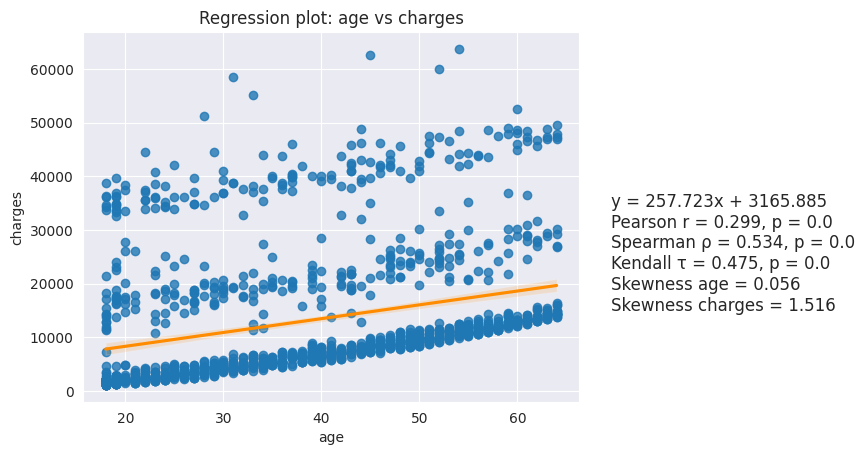

<Figure size 640x480 with 0 Axes>

In [22]:
generate_regression_plot(df=insurance, column_1='age', column_2='charges', round_to=3)

## Bar Plot

In [27]:

def generate_bar_plot(df: pd.DataFrame, numerical_feature: str, categorical_feature: str,
                      round_to: int = 3, alpha: float = 0.05, plot_type: str = "bar"):
    """
    Plots a bar or violin plot between a numerical and a categorical feature,
    and performs statistical tests (t-test or ANOVA + pairwise t-tests).

    Parameters:
    - df: DataFrame
    - numerical_feature: column name of numeric variable
    - categorical_feature: column name of categorical variable
    - round_to: number of decimal places in output
    - alpha: significance level
    - plot_type: "bar" or "violin"
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Choose plot type
    if plot_type == "bar":
        sns.barplot(data=df, x=categorical_feature, y=numerical_feature, ax=ax1)
    elif plot_type == "violin":
        sns.violinplot(data=df, x=categorical_feature, y=numerical_feature, ax=ax1, inner='box')
    else:
        raise ValueError("Invalid plot_type. Choose 'bar' or 'violin'.")

    # Grouping and filtering
    groups_list = []
    valid_groups = []

    for group in df[categorical_feature].unique():
        temp_group = df[df[categorical_feature] == group][numerical_feature]
        if len(temp_group) >= 2:
            groups_list.append(temp_group)
            valid_groups.append(group)

    num_groups = len(groups_list)

    if num_groups < 2:
        raise ValueError("It is necessary to have at least two valid groups in the categorical feature.")

    # Statistical tests
    if num_groups == 2:
        t_stat, p_value = stats.ttest_ind(*groups_list, equal_var=False)
        text_str = f"t-test:\nt={round(t_stat, round_to)}, p={round(p_value, round_to)}"
    else:
        f_stat, p_val_anova = stats.f_oneway(*groups_list)
        text_str = f"ANOVA:\nF={round(f_stat, round_to)}, p={round(p_val_anova, round_to)}\n"

        pairs = list(combinations(valid_groups, 2))
        bonferroni = round(alpha / len(pairs), round_to)
        text_str += f"\nPairwise t-tests (Bonf α={bonferroni}):\n"
        for a, b in pairs:
            vals_a = df[df[categorical_feature] == a][numerical_feature]
            vals_b = df[df[categorical_feature] == b][numerical_feature]
            t_stat, p_value = stats.ttest_ind(vals_a, vals_b, equal_var=False)
            text_str += f"{a} vs {b}: t={round(t_stat, round_to)}, p={round(p_value, round_to)}\n"

    if num_groups > 10:
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    ax2.text(0.5, 0.5, text_str.strip(), fontsize=12, ha='center', va='center', wrap=True)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return fig

   

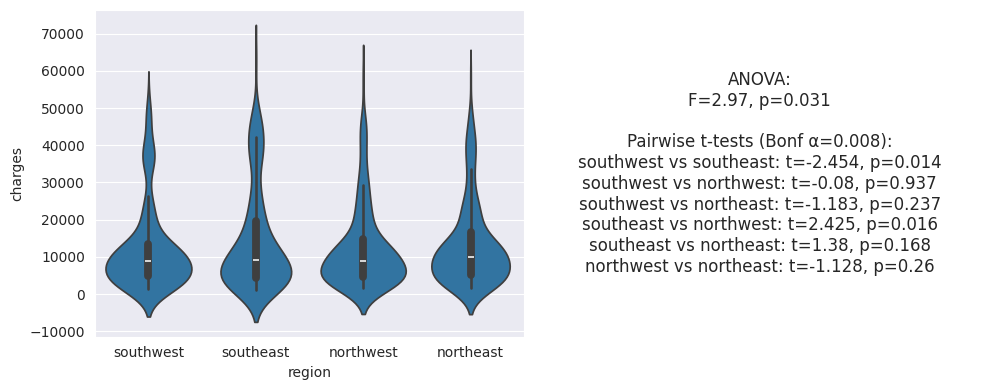

In [28]:
image = generate_bar_plot(insurance, 'charges', 'region', plot_type="violin")

## Heat Map

In [29]:
def generate_heat_map(
    df: pd.DataFrame,
    categorical_feat_1: str,
    categorical_feat_2: str,
    axis_sum: int = None,
    round_to: int = 3
):
    """
    Generates a heatmap between two categorical features in a DataFrame,
    along with Chi-squared statistical test results.

    Parameters:
        df (pd.DataFrame): A pandas DataFrame.
        categorical_feat_1 (str): Name of the first categorical feature.
        categorical_feat_2 (str): Name of the second categorical feature.
        axis_sum (int or None): Determines how proportions are calculated:
            - None: Global proportion (relative to all values).
            - 0: Column-wise (relative to column totals).
            - 1: Row-wise (relative to row totals).
        round_to (int): Number of decimal places to round numerical outputs.

    Returns:
        tuple: (fig, ax1, ax2) — the matplotlib Figure and Axes objects.
    """
    if axis_sum not in (None, 0, 1):
        raise ValueError("axis_sum must be one of: None, 0, or 1.")

    # Build contingency table
    contingency_table = pd.crosstab(df[categorical_feat_1], df[categorical_feat_2])
    
    # Chi-squared test
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    chi2 = round(chi2, round_to)
    p_value = round(p_value, round_to)

    text_str = (
        "Chi-squared test:\n"
        f"Chi-squared statistic: {chi2}\n"
        f"p-value: {p_value}\n"
    )

    # Prepare annotation labels
    values = contingency_table.values
    shape = values.shape
    labels = np.empty(shape, dtype=object)

    if axis_sum is None:
        total = values.sum()
        for i in range(shape[0]):
            for j in range(shape[1]):
                count = values[i, j]
                percent = count / total * 100
                labels[i, j] = f"{count}\n({percent:.1f}%)"
    else:
        totals = values.sum(axis=axis_sum)
        for i in range(shape[0]):
            for j in range(shape[1]):
                count = values[i, j]
                if axis_sum == 0:
                    percent = count / totals[j] * 100
                else:  # axis_sum == 1
                    percent = count / totals[i] * 100
                labels[i, j] = f"{count}\n({percent:.1f}%)"

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(
        contingency_table,
        annot=labels,
        fmt='',
        cmap='YlGnBu',
        ax=ax1,
        cbar_kws={'label': 'Count'}
    )
    ax1.set_title("Contingency Heatmap")

    ax2.text(0.5, 0.5, text_str, fontsize=12, ha='center', va='center')
    ax2.axis("off")
    ax2.set_title("Statistics")

    plt.tight_layout()
    plt.show()

    return fig, ax1, ax2


### Example - Heat Map

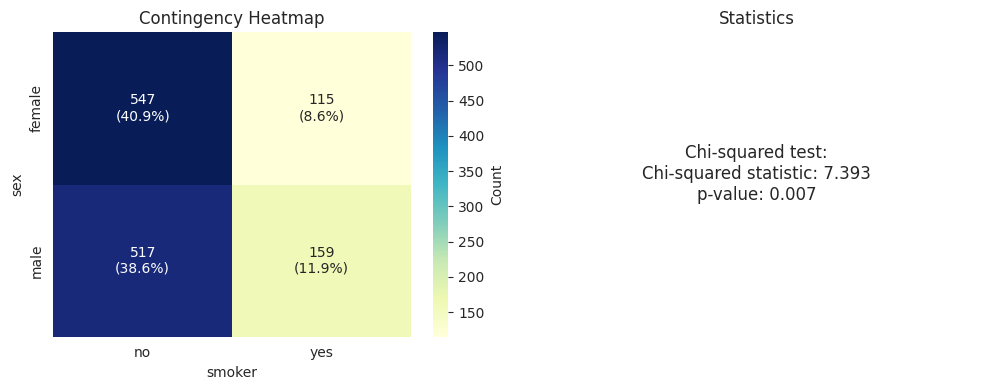

In [ ]:
_,_,_= generate_heat_map(insurance, 'sex', 'smoker')